In [1]:
import numpy as np
import pandas as pd
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from joblib import Parallel, delayed

In [2]:
def import_raw_data():
    """
    Imports data from the ODI-2025.csv file without modifying it, aside from column names.

    :return: The contents of ODI-2025.csv as a pandas dataframe.
    """
    usecols = ['Timestamp',
               'What programme are you in?',
               'Have you taken a course on machine learning?',
               'Have you taken a course on information retrieval?',
               'Have you taken a course on statistics?',
               'Have you taken a course on databases?',
               'What is your gender?',
               'I have used ChatGPT to help me with some of my study assignments ',
               'When is your birthday (date)?',
               'How many students do you estimate there are in the room?',
               'What is your stress level (0-100)?',
               'How many hours per week do you do sports (in whole hours)? ',
               'Give a random number',
               'Time you went to bed Yesterday',
               'What makes a good day for you (1)?',
               'What makes a good day for you (2)?']
    names = ['timestamp',
             'programme',
             'machine_learning',
             'information_retrieval',
             'statistics',
             'databases',
             'gender',
             'chatgpt',
             'birthday',
             'student_estimate',
             'stress',
             'sports',
             'random_number',
             'bedtime',
             'good_day_1',
             'good_day_2']

    df = pd.read_csv('files/ODI-2025.csv', usecols=usecols, sep=';')
    df.columns = names
    return df


def save_dataframe_to_file(df, filename):
    """
    Saves a pandas dataframe to the file DMT_Data.csv with separator ;.

    :param df: Pandas dataframe
    """
    df.to_csv('files/' + filename, index=False, sep=';', decimal='.')



def import_data(filename):
    return pd.read_csv('files/' + filename, sep=';')
    

def import_clean_data():
    return pd.read_csv('files/DMT_Data.csv', sep=';')

In [3]:
def column_to_string(df, colname):
    cleaned_column = df[colname].apply(lambda x: ' '.join(x.split()))
    return ' '.join(cleaned_column)


def column_wordcloud(filename, column):
    data = pd.read_csv('files/' + filename, sep=';')
    column_string = column_to_string(data, column)
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='viridis'
                          ).generate(column_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'figures/{column}_wordcloud.png', dpi=300, bbox_inches='tight')

# Data Cleaning

### Convert to Standard Formats

In [4]:
def check_ai(programme):
    return bool(re.search(r'\b(ai|artificial|artifical|inteligence|intelligence)\b', programme, re.IGNORECASE))


def check_cs(programme):
    return bool(re.search(r'\b(cs|computer science|comp sci)\b', programme, re.IGNORECASE))


def check_cls(programme):
    return bool(re.search(r'\b(cls|computational science)\b', programme, re.IGNORECASE))


def check_econometrics(programme):
    return bool(re.search(r'\b(econometrics|eor)\b', programme, re.IGNORECASE))


def check_finance(programme):
    return bool(re.search(r'\b(finance|fintech)\b', programme, re.IGNORECASE))


def check_business(programme):
    return bool(re.search(r'\b(business|BA)\b', programme, re.IGNORECASE))


def check_bioinformatics(programme):
    return bool(re.search(r'bio', programme, re.IGNORECASE))


def clean_programmes(df):
    for idx, programme in df['programme'].items():
        if check_ai(programme):
            df.at[idx, 'programme'] = 'Artificial Intelligence'
        elif check_cs(programme):
            df.at[idx, 'programme'] = 'Computer Science'
        elif check_cls(programme):
            df.at[idx, 'programme'] = 'Computational Science'
        elif check_econometrics(programme):
            df.at[idx, 'programme'] = 'Econometrics'
        elif check_finance(programme):
            df.at[idx, 'programme'] = 'Finance'
        elif check_business(programme):
            df.at[idx, 'programme'] = 'Business Analytics'
        elif check_bioinformatics(programme):
            df.at[idx, 'programme'] = 'Bioinformatics'
        else:
            df.at[idx, 'programme'] = 'Other'
            # print(df.at[idx, 'programme'])
    return df

In [5]:
def convert_course_experience(df):
    for column in ['machine_learning', 'information_retrieval', 'statistics', 'databases']:
        for idx, value in df[column].items():
            if value in ['yes', '1', 'mu', 'ja']:
                df.at[idx, column] = 'yes'
            elif value in ['no', '0', 'sigma', 'nee']:
                df.at[idx, column] = 'no'
    return df

In [6]:
def convert_gender(df):
    for idx, value in df['gender'].items():
        if value != 'male' and value != 'female':
            df.at[idx, 'gender'] = 'other'
    return df

In [7]:
def convert_birthdays(df):
    for idx, value in df['birthday'].items():
        value = str(value)
        if re.match(r'^\d{2}-\d{2}-\d{4}$', value):
            # dd-mm-yyyy
            df.at[idx, 'birthday'] = value.replace('-', '/')
        elif re.match(r'^\d{2}-\d{2}-\d{2}$', value):
            # mm-dd-yy
            mm, dd, yy = value.split('-')
            century = '20' if int(yy) <= 25 else '19'
            formatted_value = f"{dd}/{mm}/{century}{yy}"
            df.at[idx, 'birthday'] = formatted_value
        elif re.match(r'^\d{8}$', value):
            # ddmmyyyy
            if float(value[4:]) > 1925:
                formatted_value = f"{value[:2]}/{value[2:4]}/{value[4:]}"
                df.at[idx, 'birthday'] = formatted_value
        elif re.match(r'^\d{2}\.\d{2}\.\d{4}$', value):
            # dd.mm.yyyy
            df.at[idx, 'birthday'] = value.replace('.', '/')
        elif re.match(r'^\d{4}\.\d{2}\.\d{2}$', value):
            # yyyy.mm.dd
            yyyy, mm, dd = value.split('.')
            formatted_value = f"{dd}/{mm}/{yyyy}"
            df.at[idx, 'birthday'] = formatted_value
        elif re.match(r'^\d{4}-\d{2}-\d{2}$', value):
            # yyyy-mm-dd
            yyyy, mm, dd = value.split('-')
            formatted_value = f"{dd}/{mm}/{yyyy}"
            df.at[idx, 'birthday'] = formatted_value
        elif re.match(r'^\d{2} \d{2} \d{4}$', value):
            # dd mm yyyy
            df.at[idx, 'birthday'] = value.replace(' ', '/')
    return df

In [8]:
def remove_non_numeric(x):
    x = str(x)
    x = re.sub(r'[^0-9.,E+\-]', '', x)
    if '-' in x[1:]:
        x = x.split('-', 1)[0]
    if x.count('E') > 1:
        x = x.replace('E', '')
    
    return x

In [9]:
def remove_non_numeric_in_column(df, column):
    df[column] = df[column].apply(
        lambda x: remove_non_numeric(x)
    )
    return df

In [10]:
def clean_and_convert_student_estimate(df):
    df = remove_non_numeric_in_column(df, 'student_estimate')
    df['student_estimate'] = df['student_estimate'].replace('', np.nan)
    df['student_estimate'] = df['student_estimate'].astype(float)
    return df

In [11]:
def clean_and_convert_stress(df):
    df['stress'] = df['stress'].astype(str)
    df['stress'] = df['stress'].apply(lambda x: re.sub(',', '.', x))
    df = remove_non_numeric_in_column(df, 'stress')
    df['stress'] = df['stress'].replace('', np.nan)
    df['stress'] = df['stress'].astype(float)
    return df

In [12]:
def clean_and_convert_sports(df):
    df['sports'] = df['sports'].astype(str)
    for idx, value in df['sports'].items():
        if value == 'zero':
            # the one case that had value 'zero'
            df.at[idx, 'sports'] = str(0)
        elif bool(re.search(r'-', value)):
            # range a-b
            lower, higher = value.split('-')
            df.at[idx, 'sports'] = lower
        elif bool(re.search(r'[.,]', value)):
            # decimal (question asked for whole hours)
            integral, _ = re.split(r'[.,]', value, maxsplit=1)
            df.at[idx, 'sports'] = integral
    df = remove_non_numeric_in_column(df, 'sports')
    df['sports'] = df['sports'].replace('', np.nan)
    df['sports'] = df['sports'].astype(float)
    return df

In [13]:
def clean_and_convert_random_number(df):
    df['random_number'] = df['random_number'].astype(str)
    # international notation '.' = decimal, ',' = exponent of 10^3
    df['random_number'] = df['random_number'].apply(
        lambda x: re.sub(r'\.', '', x) if x.count('.') > 1 else x
    )
    df['random_number'] = df['random_number'].apply(
        lambda x: re.sub(r',', '.', x) if x.count(',') == 1 else x
    )
    df = remove_non_numeric_in_column(df, 'random_number')
    df['random_number'] = df['random_number'].replace('', np.nan)
    df['random_number'] = df['random_number'].astype(float)
    return df

In [14]:
def convert_to_military_time(time_string):
    formats = [
        "%H:%M", "%Hh%M", "%Hu%M", "%H.%M", "%I.%M", "%H-%M",
        "%H", "%I", "%H%M", "%I%M", "%I%p", "%H%p",
        "%H:%M %p", "%I:%M %p", "%H %p", "%I %p",
        "%H:%M%p", "%I:%M%p", "%I.%M%p"
    ]
    
    for format in formats:
        try:
            dt = datetime.strptime(time_string.strip().lower(), format)
            # Round minutes
            minute = dt.minute
            if minute < 15:
                rounded_minute = 0
            elif minute < 45:
                rounded_minute = 30
            else:
                dt += timedelta(hours=1)
                rounded_minute = 0
            dt = dt.replace(minute=rounded_minute, second=0, microsecond=0)
            if 9 <= dt.hour <= 12:
                dt = dt.replace(hour=(dt.hour + 12) % 24)
            return dt.strftime("%H:%M")
        except ValueError:
            continue

    print(f"Could not parse time_string: {time_string}")
    return time_string

In [15]:
def convert_bedtime(df):
    for idx, value in df['bedtime'].items():
        df.at[idx, 'bedtime'] = convert_to_military_time(value)
    return df

In [16]:
def clean_and_save(df):
    df.drop(df.tail(1).index,inplace=True)
    df = clean_programmes(df)
    df = convert_course_experience(df)
    df = convert_birthdays(df)
    df = clean_and_convert_student_estimate(df)
    df = clean_and_convert_stress(df)
    df = clean_and_convert_sports(df)
    df = clean_and_convert_random_number(df)
    df = convert_bedtime(df)
    save_dataframe_to_file(df, 'DMT_Data.csv')

In [17]:
clean_and_save(import_raw_data())

Could not parse time_string: Midnight
Could not parse time_string: 3 AM x)
Could not parse time_string: around midnight
Could not parse time_string: 1743502757


After data formatting and saving to DMT_Data.csv, some birthdays were manually adjusted to fit the format dd/mm/yyyy, and some bedtimes to hh:mm. Furthermore, rows 174, 240 were removed for being invalid. The result was saved to DMT_Data_Manual.csv.

### Combining Data

In [18]:
def calculate_age(df):
    df['birthday'] = pd.to_datetime(df['birthday'], format='%d/%m/%Y', errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    df['age'] = df.apply(
        lambda row: (row['timestamp'].year - row['birthday'].year) 
                    - ((row['timestamp'].month, row['timestamp'].day) < 
                       (row['birthday'].month, row['birthday'].day)),
        axis=1
    ).astype(float)
    return df

In [19]:
df = import_data('DMT_Data_Manual.csv')
save_dataframe_to_file(calculate_age(df), 'DMT_Data_Age.csv')

### Removing Invalid Data
Removal of data based on values outside of a realistic/predetermined range.

In [20]:
def remove_invalid_ages(df):
    df['age'] = df['age'].where((df['age'] >= 16) & (df['age'] <= 80), np.nan)
    return df

In [21]:
def remove_invalid_student_estimates(df):
    df['student_estimate'] = df['student_estimate'].where((df['student_estimate'] >= 50) & (df['student_estimate'] <= 800), np.nan)
    return df

In [22]:
def remove_invalid_stress(df):
    df['stress'] = df['stress'].where((df['stress'] >= 0) & (df['stress'] <= 100), np.nan)
    return df

In [23]:
def remove_invalid_sports(df):
    df['sports'] = df['sports'].where((df['sports'] >= 0) & (df['sports'] <= 40), np.nan)
    return df

In [24]:
def remove_invalid_bedtimes(df):
    pattern = r'^\d{2}:\d{2}$'
    df['bedtime'] = df['bedtime'].astype(str).apply(
        lambda x: x if re.match(pattern, x) else np.nan
    )
    return df

In [25]:
def remove_unused_columns(df):
    return df.drop(['timestamp', 'birthday', 'random_number', 'good_day_1', 'good_day_2'], axis=1)

In [26]:
def remove_invalid_data(df):
    df = remove_invalid_ages(df)
    df = remove_invalid_student_estimates(df)
    df = remove_invalid_stress(df)
    df = remove_invalid_sports(df)
    df = remove_invalid_bedtimes(df)
    df = remove_unused_columns(df)
    save_dataframe_to_file(df, 'DMT_Data_Clean.csv')

In [27]:
remove_invalid_data(import_data('DMT_Data_Age.csv'))

### Imputation
Replacing missing values
#### Method 1: Replace with Median

In [28]:
def median_bedtime(bedtimes):
    bedtimes_DT = pd.to_datetime(bedtimes, format='%H:%M', errors='coerce')
    bedtimes_seconds = (bedtimes_DT.dt.hour * 3600 + bedtimes_DT.dt.minute * 60)
    # Center around midnight s.t. 22:00 becomes -02:00
    bedtimes_centered = bedtimes_seconds.apply(lambda s: s - (24 * 3600) if s > (12 * 3600) else s)
    median_seconds = bedtimes_centered.median()
    median_time = (datetime.min + timedelta(seconds=median_seconds)).strftime('%H:%M')
    return median_time

In [29]:
def impute_median(df):
    cols = ['student_estimate', 'stress', 'sports', 'age']
    for col in cols:
        median = df[col].median()
        print('median for col ' + col + ': ' + str(median))
        df[col] = df[col].fillna(median)
    return df

In [30]:
save_dataframe_to_file(impute_median(import_data('DMT_Data_Clean.csv')), 'DMT_Data_Median.csv')

median for col student_estimate: 350.0
median for col stress: 40.0
median for col sports: 5.0
median for col age: 23.0


#### Method 2: Class Center Based Median Value Imputation

In [31]:
def separate_missing_by_programme(df):
    complete_data = {}
    incomplete_data = {}
    numeric_cols = df.select_dtypes(include='number').columns
    for idx, row in df.iterrows():
        class_label = row['programme']
        row_numeric = row[numeric_cols]
        missing_cols = row_numeric[row_numeric.isnull()].index.tolist()

        if len(missing_cols) > 0:
            if class_label not in incomplete_data:
                incomplete_data[class_label] = {}
            incomplete_data[class_label][idx] = row_numeric
        else:
            if class_label not in complete_data:
                complete_data[class_label] = pd.DataFrame(columns=row_numeric.index)
            complete_data[class_label] = pd.concat([complete_data[class_label], pd.DataFrame([row_numeric])], ignore_index=True)
    return complete_data, incomplete_data

In [32]:
def find_thresholds(complete_data):
    thresholds = {}
    for class_label in complete_data:
        class_df = complete_data[class_label]
        class_mean = class_df.mean()
        euclidean_distances = np.sqrt(((class_df - class_mean) ** 2).sum(axis=1))
        thresholds[class_label] = euclidean_distances.median()
    return thresholds

In [33]:
def select_best_std(base_distance, missing_cols, row, class_std, class_mean):
    min_distance = base_distance
    best_col = ''
    for col in missing_cols:
        row_copy = row.copy()
        row_copy[col] -= class_std[col]
        euclidean_distance = np.sqrt(((row_copy - class_mean) ** 2).sum())
        if euclidean_distance < min_distance:
            best_col = col
    if best_col != '':
        row[best_col] -= class_std[best_col]
    return row

In [34]:
def impute_CCMVI(df):
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].astype(float)
    complete_data, incomplete_data = separate_missing_by_programme(df)
    thresholds = find_thresholds(complete_data)
    for class_label, incomplete_dict in incomplete_data.items():
        class_df = complete_data[class_label]
        class_mean = class_df.mean()
        class_std = class_df.std()
        for idx, row in incomplete_dict.items():
            missing_cols = row[row.isnull()].index.tolist()
            for col in missing_cols:
                row[col] = class_mean[col]
            euclidean_distance = np.sqrt(((row - class_mean) ** 2).sum())
            if euclidean_distance > thresholds[class_label]:
                row = select_best_std(euclidean_distance, missing_cols, row, class_std, class_mean)
            incomplete_data[class_label][idx] = row.astype(float)
    for class_label, incomplete_dict in incomplete_data.items():
        for idx, row in incomplete_dict.items():
            df.loc[idx, row.index] = row.astype(float)
    return df

In [35]:
df = import_data('DMT_Data_Clean.csv')
save_dataframe_to_file(impute_CCMVI(df), 'DMT_Data_CCMVI.csv')

### Transforming data

#### Numerical Classifier

In [36]:
def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns)

In [37]:
def normalize(df, columns):
    for col in columns:
        min_value = df[col].min()
        max_value = df[col].max()
        print(f'Min value for {col}: {min_value}')
        print(f'Max value for {col}: {max_value}')
        df[col] = (df[col]-min_value)/(max_value-min_value)
    return df

In [38]:
def bedtime_to_mins_past_three(df):
    bedtimes = pd.to_datetime(df['bedtime'], format='%H:%M').dt.time
    bedtimes_mins = bedtimes.apply(lambda t: t.hour * 60 + t.minute)
    df['bedtime'] = (bedtimes_mins - 900) % 1440
    return df

In [39]:
def encode_numerically(df):
    categorical = ['programme', 'machine_learning', 'information_retrieval', 'statistics', 'databases', 'gender', 'chatgpt']
    numerical = ['stress', 'student_estimate', 'sports', 'bedtime', 'age']
    df = bedtime_to_mins_past_three(df)
    df = one_hot_encode(df, categorical)
    df = normalize(df, numerical)
    save_dataframe_to_file(df, 'DMT_Data_Numerical.csv')

In [40]:
df = import_data('DMT_Data_CCMVI.csv')
encode_numerically(df)

Min value for stress: 0.0
Max value for stress: 100.0
Min value for student_estimate: 80.0
Max value for student_estimate: 600.0
Min value for sports: 0.0
Max value for sports: 23.0
Min value for bedtime: 240
Max value for bedtime: 1320
Min value for age: 19.0
Max value for age: 42.0


#### Categorical Classifier

In [41]:
def encode_programme(df):
    programmes = df['programme']
    programme_mapping = {program: idx for idx, program in enumerate(programmes.unique())}
    # make 'Other' the last entry
    last_integer = len(programme_mapping) - 1
    last_programme = [programme for programme, value in programme_mapping.items() if value == last_integer][0]
    other_integer = programme_mapping['Other']
    programme_mapping['Other'] = last_integer
    programme_mapping[last_programme] = other_integer
    df['programme'] = df['programme'].map(programme_mapping)
    print("Programmes mapped:", programme_mapping)
    return df

In [42]:
def encode_student_estimate(df):
    # low = 0-300, Medium = 301-450, High = 451+
    bins = [float('-inf'), 300, 450, float('inf')]
    labels = ['low', 'medium', 'high']
    df['student_estimate'] = pd.cut(df['student_estimate'], bins=bins, labels=labels, right=True)
    return df

In [43]:
def encode_stress(df):
    # Low = 0-33, Medium = 34-66, High = 67-100
    # lower_third = df['stress'].quantile(0.33)
    # upper_two_third = df['stress'].quantile(0.66)
    # bins = [float('-inf'), lower_third, upper_two_third, 100]
    bins = [float('-inf'), 33, 66, 100]
    labels = ['low', 'medium', 'high']
    df['stress'] = pd.cut(df['stress'], bins=bins, labels=labels, right=True)
    return df

In [44]:
def encode_sports(df):
    # Low = 0-2, Medium = 3-6, High = 7+
    bins = [float('-inf'), 2, 6, float('inf')]
    labels = ['low', 'medium', 'high']
    df['sports'] = pd.cut(df['sports'], bins=bins, labels=labels, right=True)
    return df

In [45]:
def encode_bedtime(df):
    df = bedtime_to_mins_past_three(df)
    # Early = before 10pm, Middle = 10:01pm-1am, Late = past 1:01am
    bins = [float('-inf'), 420, 600, float('inf')]
    labels = ['early', 'middle', 'late']
    df['bedtime'] = pd.cut(df['bedtime'], bins=bins, labels=labels, right=True)
    return df

In [46]:
def encode_age(df):
    # Young = 0-21, Middle = 22-25, Old = 26+
    bins = [float('-inf'), 21, 25, float('inf')]
    labels = ['young', 'middle', 'old']
    df['age'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
    return df

In [47]:
def encode_classifiers(df):
    categorical = ['programme', 'machine_learning', 'information_retrieval', 'statistics', 'databases', 'gender', 'chatgpt']
    numerical = ['student_estimate', 'sports', 'bedtime', 'age']
    df = bedtime_to_mins_past_three(df)
    df = one_hot_encode(df, categorical)
    # make stress categorical for classifiers
    df = encode_stress(df)
    df = normalize(df, numerical)
    save_dataframe_to_file(df, 'DMT_Data_Classifiers.csv')

In [48]:
df = import_data('DMT_Data_CCMVI.csv')
encode_classifiers(df)

Min value for student_estimate: 80.0
Max value for student_estimate: 600.0
Min value for sports: 0.0
Max value for sports: 23.0
Min value for bedtime: 240
Max value for bedtime: 1320
Min value for age: 19.0
Max value for age: 42.0


## Plotting

In [49]:
def plot_bedtimes(ax, df, title):
    bedtimes_DT = pd.to_datetime(df['bedtime'], format='%H:%M', errors='coerce')
    bedtimes_seconds = bedtimes_DT.dt.hour * 3600 + bedtimes_DT.dt.minute * 60
    half_day = 43200
    centered_bedtimes = bedtimes_seconds.apply(lambda x: x - 86400 if x > half_day else x)
    sorted_bedtimes = np.sort(centered_bedtimes)
    counts = pd.Series(sorted_bedtimes).value_counts().sort_index()
    if counts.sum() > 0:
        counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
    else:
        print(f"No valid data to plot for {title}")
    ax.set_title(title)
    ax.set_xlabel("bedtime")
    ax.set_ylabel("Count")
    tick_labels = [str(datetime.utcfromtimestamp(x).strftime('%H:%M')) for x in counts.index]
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

In [123]:
def plot_dist(ax, df, column, title):
    # Plot the histogram
    print(df[column])
    df[column].plot(kind='hist', bins=10, ax=ax)
    
    # Access the patches (bars) of the histogram to get the counts of each bin
    counts, edges, patches = ax.hist(df[column], bins=10, color='#1f77b4', edgecolor='black', alpha=0.7)
    
    # Print the sum of the counts (total number of elements)
    total_counts = counts.sum()
    print(f"Sum of counts in all bins for {column}: {total_counts}")
    
    # Plot labels and grid
    ax.set_title(title,fontweight="bold", size=18)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

0      78.000000
1      41.500000
2      36.139375
3      60.000000
4      50.000000
         ...    
237    40.000000
238    60.000000
239    35.000000
240    75.000000
241    45.000000
Name: stress, Length: 242, dtype: float64
Sum of counts in all bins for stress: 242.0
0      78.0
1      40.0
2      40.0
3      60.0
4      50.0
       ... 
237    40.0
238    60.0
239    35.0
240    75.0
241    45.0
Name: stress, Length: 242, dtype: float64
Sum of counts in all bins for stress: 242.0
0      78.0
1       NaN
2       NaN
3      60.0
4      50.0
       ... 
237    40.0
238    60.0
239    35.0
240    75.0
241    45.0
Name: stress, Length: 242, dtype: float64
Sum of counts in all bins for stress: 222.0


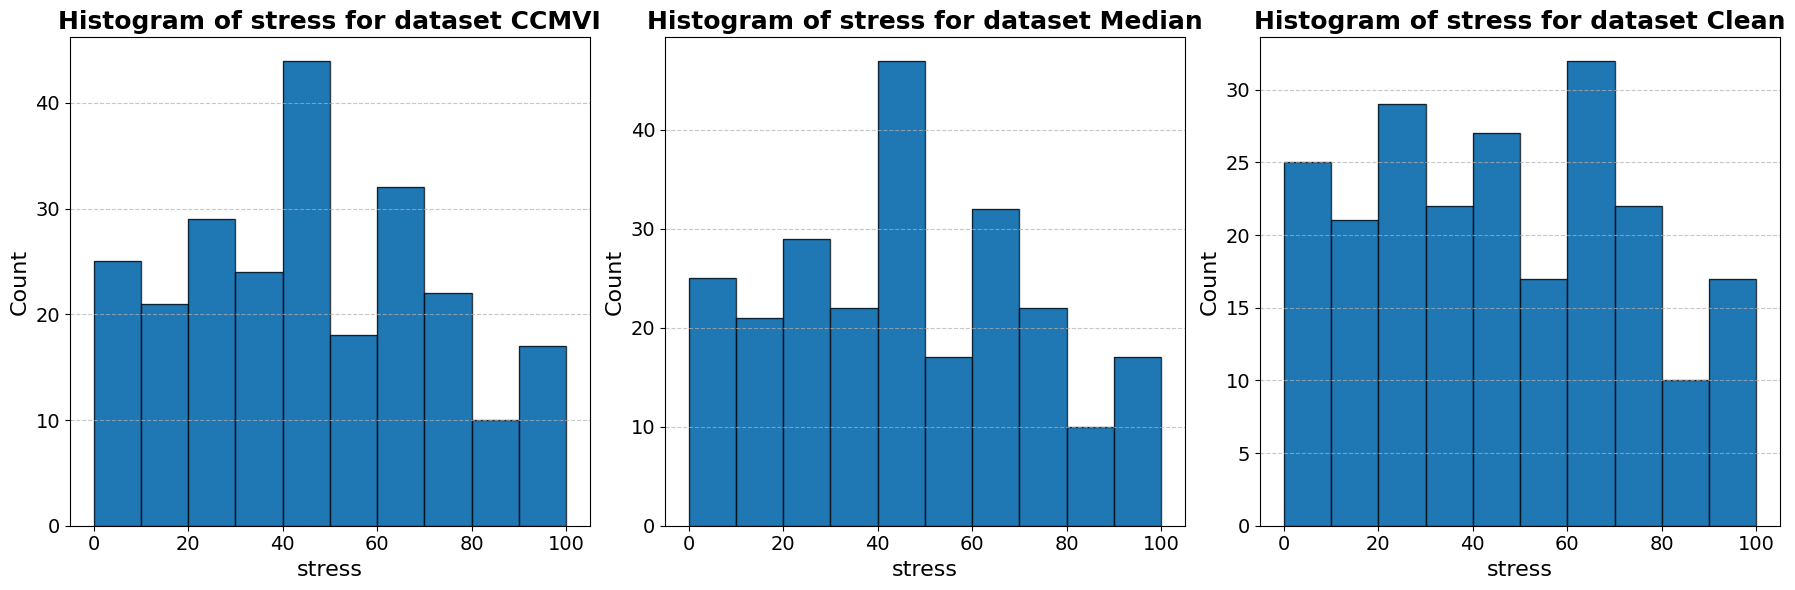

In [124]:
def plot_imputations():
    cols = ['stress']
    
    # Import the dataframes
    df_ccmvi = import_data('DMT_Data_CCMVI.csv')
    df_median = import_data('DMT_Data_Median.csv')
    df_na = import_data('DMT_Data_Clean.csv')
    
    for col in cols:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        title = f'Histogram of {col} for dataset '
        if col == 'bedtime':
            plot_bedtimes(axes[0], df_ccmvi, title + 'CCMVI')
            plot_bedtimes(axes[1], df_median, title + 'Median')
            plot_bedtimes(axes[2], df_na, title + 'Clean')
        else:
            plot_dist(axes[0], df_ccmvi, col, title + 'CCMVI')
            plot_dist(axes[1], df_median, col, title + 'Median')
            plot_dist(axes[2], df_na, col, title + 'Clean')
        
        # Save the figure to a file
        plt.tight_layout()
        plt.show()

def plot_value_counts(ax, df, column, title, xlab):
    counts = df[column].value_counts(dropna=True).head(10)
    counts.plot(kind='bar', ax=ax)
    
    ax.set_title(title,fontweight="bold", size=15)
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(counts.index, fontsize=12)
    ax.tick_params(axis='x', rotation=65)
    
plot_imputations()

### Classifiers

In [6]:
numerical_df = import_data('DMT_Data_Numerical.csv')
correlations = numerical_df.corr()['stress'].drop('stress')
abs_correlations = correlations.abs().sort_values(ascending=False)
print(abs_correlations)

sports                               0.272291
bedtime                              0.198764
gender_male                          0.169760
gender_other                         0.140639
chatgpt_yes                          0.136468
information_retrieval_unknown        0.131904
chatgpt_not willing to say           0.130109
information_retrieval_yes            0.126233
gender_female                        0.102008
machine_learning_yes                 0.089999
machine_learning_no                  0.085419
databases_yes                        0.081912
databases_no                         0.079427
programme_Econometrics               0.070870
statistics_unknown                   0.062013
programme_Other                      0.061015
statistics_yes                       0.054195
information_retrieval_no             0.047144
chatgpt_no                           0.035979
programme_Bioinformatics             0.035029
machine_learning_unknown             0.033061
student_estimate                  

### Decision Tree

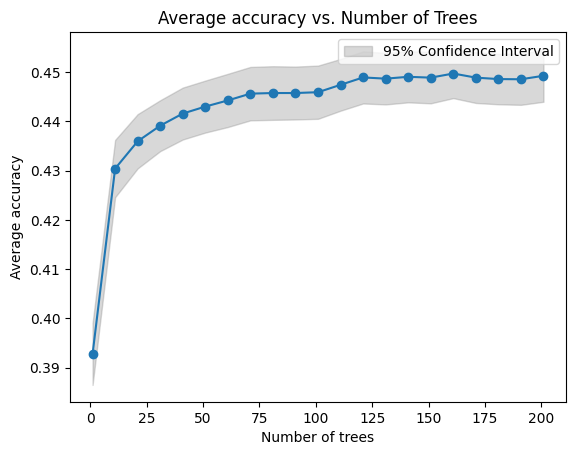

In [138]:
df = import_data('DMT_Data_Classifiers.csv')
y = df['stress']
X = df[['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown',
                       'chatgpt_not willing to say', 'information_retrieval_yes']]
# lower_bounds, upper_bounds, average_acc, max_acc = k_fold(X, y, 6, stop_early=False)
plt.fill_between(range(1, len(average_acc)*10, 10), lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.plot(range(1, len(average_acc)*10, 10), average_acc, marker='o')
plt.title("Average accuracy vs. Number of Trees")
plt.xlabel("Number of trees")
plt.ylabel("Average accuracy")
plt.legend()
plt.show()

In [132]:
def k_fold(X, y, d, max_iter=30, stop_early=True, random_forest=True, n_jobs=-1):
    average_acc = []
    lower_bounds = []
    upper_bounds = []
    max_acc = 0
    worse_accs = 0
    n = 1

    def evaluate_model(j, d, n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=j)
        if random_forest:
            clf = RandomForestClassifier(max_depth=d, n_estimators=n, random_state=j)
        else:
            clf = tree.DecisionTreeClassifier(max_depth=d)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        return accuracy_score(y_test, y_pred)

    while n <= 201:
        print(f"trees: {n}")
        scores = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_model)(j, d, n) for j in range(300)
        )
        mean_acc = np.mean(scores)
        ci = 1.96 * np.std(scores) / np.sqrt(len(scores))
        average_acc.append(mean_acc)
        lower_bounds.append(mean_acc - ci)
        upper_bounds.append(mean_acc + ci)

        if mean_acc > max_acc:
            worse_accs = 0
            max_acc = mean_acc
            print(f'New max acc: {max_acc:.4f} at trees {n}')
        elif stop_early:
            worse_accs += 1
            print(f'mean acc: {mean_acc:.4f}, worse_accs: {worse_accs}')
            if worse_accs == 3:
                print(f'Best depth: {d - 3}')
                break
        n += 10

    return lower_bounds, upper_bounds, average_acc, max_acc

In [8]:
def feature_selection(df, abs_correlations, random_forest=True):
    y = df['stress']
    predictors = []
    num_predictors = []
    max_accs = []
    best_acc = 0
    i = 0
    while i < len(abs_correlations.index):
        col = abs_correlations.index[i]
        predictors.append(col)
        num_predictors.append(len(predictors))
        X = df[predictors]
        lower_bounds, upper_bounds, accuracies, max_acc = k_fold(X, y, random_forest=random_forest)
        max_accs.append(max_acc)
        print(f'Attributes: {predictors}, Accuracy: {max_acc}')
        i += 1
    return num_predictors, max_accs

Attributes: ['sports'], Accuracy: 0.44395833333333334
Attributes: ['sports', 'bedtime'], Accuracy: 0.4103333333333333
Attributes: ['sports', 'bedtime', 'gender_male'], Accuracy: 0.40529166666666666
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other'], Accuracy: 0.40462499999999996
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes'], Accuracy: 0.403125
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown'], Accuracy: 0.40208333333333335
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatgpt_not willing to say'], Accuracy: 0.4057916666666667
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatgpt_not willing to say', 'information_retrieval_yes'], Accuracy: 0.40558333333333335
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'infor

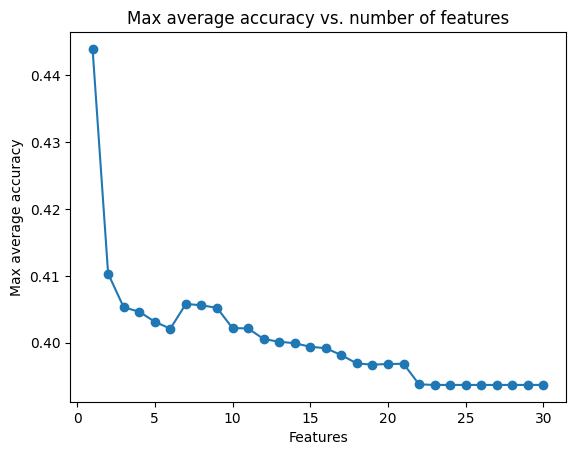

In [21]:
classifier_df = import_data('DMT_Data_Classifiers.csv')
num_predictors, max_accs = feature_selection(classifier_df, abs_correlations, random_forest=False)
plt.plot(num_predictors, max_accs, marker='o')
plt.title("Max average accuracy vs. number of features")
plt.xlabel("Features")
plt.ylabel("Max average accuracy")
plt.locator_params(axis='x', nbins=11)
# plt.legend()
plt.show()

Depth: 1
New max acc: 0.4332 at depth 1
Depth: 2
New max acc: 0.4371 at depth 2
Depth: 3
mean acc: 0.4251, worse_accs: 1
Depth: 4
mean acc: 0.4213, worse_accs: 2
Depth: 5
mean acc: 0.4212, worse_accs: 3
Best depth: 2
Attributes: ['sports'], Accuracy: 0.43712500000000004
Depth: 1
New max acc: 0.4123 at depth 1
Depth: 2
New max acc: 0.4208 at depth 2
Depth: 3
mean acc: 0.4142, worse_accs: 1
Depth: 4
mean acc: 0.4046, worse_accs: 2
Depth: 5
mean acc: 0.4002, worse_accs: 3
Best depth: 2
Attributes: ['sports', 'bedtime'], Accuracy: 0.42075
Depth: 1
New max acc: 0.3993 at depth 1
Depth: 2
New max acc: 0.4114 at depth 2
Depth: 3
New max acc: 0.4130 at depth 3
Depth: 4
mean acc: 0.4097, worse_accs: 1
Depth: 5
mean acc: 0.4115, worse_accs: 2
Depth: 6
mean acc: 0.4097, worse_accs: 3
Best depth: 3
Attributes: ['sports', 'bedtime', 'gender_male'], Accuracy: 0.4129583333333333
Depth: 1
New max acc: 0.4047 at depth 1
Depth: 2
New max acc: 0.4142 at depth 2
Depth: 3
mean acc: 0.4120, worse_accs: 1
De

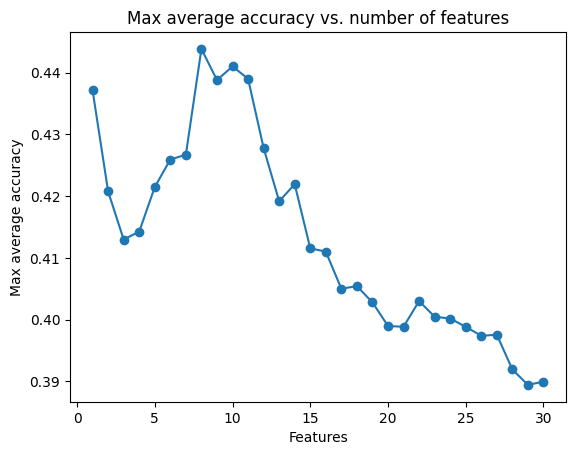

In [14]:
classifier_df = import_data('DMT_Data_Classifiers.csv')
num_predictors, max_accs = feature_selection(classifier_df, abs_correlations)
plt.plot(num_predictors, max_accs, marker='o')
plt.title("Max average accuracy vs. number of features")
plt.xlabel("Features")
plt.ylabel("Max average accuracy")
plt.locator_params(axis='x', nbins=11)
# plt.legend()
plt.show()

In [ ]:
abs_correlations.index

Depth: 1
New max acc: 0.4003 at depth 1
Depth: 2
New max acc: 0.4253 at depth 2
Depth: 3
New max acc: 0.4311 at depth 3
Depth: 4
New max acc: 0.4367 at depth 4
Depth: 5
New max acc: 0.4387 at depth 5
Depth: 6
New max acc: 0.4438 at depth 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30


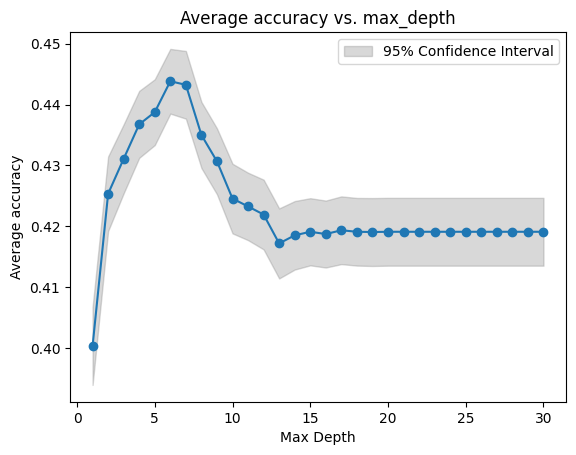

In [16]:
X_idk = classifier_df[['bedtime', 'sports', 'gender_other', 'gender_male', 'information_retrieval_unknown', 'chatgpt_yes',
                   'chatgpt_not willing to say', 'information_retrieval_yes']]
X_new = classifier_df[['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown',
                       'chatgpt_not willing to say', 'information_retrieval_yes']]

y = classifier_df['stress']
lower_bounds, upper_bounds, accuracies, max_acc = k_fold(X_new, y, stop_early=False)

plt.fill_between(range(1, len(accuracies)+1), lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("Average accuracy vs. max_depth")
plt.xlabel("Max Depth")
plt.ylabel("Average accuracy")
plt.legend()
plt.show()

In [139]:
def run_classifier_at_depth(X, y, depth, trees, random_forest=True):
    scores = []
    y_test_final = None
    y_pred_final = None

    for j in range(300):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=j
        )
        if random_forest:
            clf = RandomForestClassifier(max_depth=depth, n_estimators=trees, random_state=j)
        else:
            clf = tree.DecisionTreeClassifier(max_depth=depth)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

        if j == 299:
            y_test_final = y_test
            y_pred_final = y_pred

    mean_acc = np.mean(scores)
    ci = 1.96 * np.std(scores) / np.sqrt(len(scores))
    
    return mean_acc, ci, y_test_final, y_pred_final

In [141]:
X_new = df[['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown',
                       'chatgpt_not willing to say', 'information_retrieval_yes']]

y = df['stress']
mean_acc, ci, y_test, y_pred = run_classifier_at_depth(X, y, 6, 120, random_forest=True)
print(mean_acc)
print(mean_acc - ci, mean_acc + ci)
print(confusion_matrix(y_test, y_pred))

0.44912500000000005
0.4438314311738992 0.4544185688261009
[[ 5  6  6]
 [ 6 20 13]
 [ 1  8 15]]


### Naive Bayes

Attributes: ['sports'], Accuracy: 0.41568749999999993
Attributes: ['sports', 'bedtime'], Accuracy: 0.4285625
Attributes: ['sports', 'bedtime', 'gender_male'], Accuracy: 0.4305
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other'], Accuracy: 0.42881250000000004
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes'], Accuracy: 0.43325
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown'], Accuracy: 0.4344374999999999
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatgpt_not willing to say'], Accuracy: 0.43799999999999994
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatgpt_not willing to say', 'information_retrieval_yes'], Accuracy: 0.4438125
Attributes: ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatg

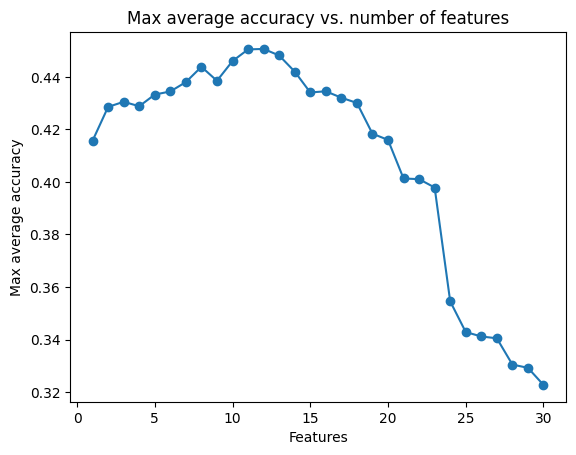

In [19]:
features = ['gender_male', 'sports', 'bedtime', 'chatgpt_yes', 'chatgpt_not willing to say', 'gender_other',
       'information_retrieval_yes']

target = 'stress'

def naive_bayes(df, features, target):
    average_accuracy = []
    for i in range(200):
        X = df[features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        average_accuracy.append(acc)
    return average_accuracy, y_test, y_pred

def feature_selection(df, abs_corr, random_forest=False):
    y = df['stress']
    predictors = []
    num_predictors = []
    max_accs = []
    best_acc = 0
    i = 0
    while i < len(abs_corr.index):
        col = abs_corr.index[i]
        predictors.append(col)
        num_predictors.append(len(predictors))
        X = df[predictors]
        average_accuracy, _, _ = naive_bayes(df, predictors, 'stress')
        max_acc = np.mean(average_accuracy)
        max_accs.append(max_acc)
        print(f'Attributes: {predictors}, Accuracy: {max_acc}')
        i += 1
    return num_predictors, max_accs

num_predictors, max_accs = feature_selection(classifier_df, abs_correlations)
plt.plot(num_predictors, max_accs, marker='o')
plt.title("Max average accuracy vs. number of features")
plt.xlabel("Features")
plt.ylabel("Max average accuracy")
plt.locator_params(axis='x', nbins=11)
# plt.legend()
plt.show()

In [20]:
features = ['sports', 'bedtime', 'gender_male', 'gender_other', 'chatgpt_yes', 'information_retrieval_unknown', 'chatgpt_not willing to say',
            'information_retrieval_yes', 'gender_female', 'machine_learning_yes', 'machine_learning_no', 'databases_yes']

X = classifier_df[['bedtime', 'sports', 'gender_other', 'gender_male', 'information_retrieval_unknown', 'chatgpt_yes',
                   'chatgpt_not willing to say', 'information_retrieval_yes']]

target = 'stress'
average_accuracy, y_test, y_pred = naive_bayes(classifier_df, features, 'stress')
mean_accuracy = np.mean(average_accuracy)
ci = 1.96 * np.std(average_accuracy)/np.sqrt(len(average_accuracy))

low = mean_accuracy - ci
up = mean_accuracy + ci
print(mean_accuracy,'with error bounds of ',low,up)
print(ci)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

0.450625 with error bounds of  0.4438248706354217 0.4574251293645783
0.006800129364578294
Confusion Matrix:
 [[ 5  8  8]
 [ 1 21  8]
 [ 1 10 18]]


## Notes Classifier Feature Selection
de features zijn gekozen door om de beurt de hoogste en laagste correlations met stress toe te voegen en de classifiers te runnen, en de feature set met de hoogste accuracy te kiezen. voor random forest geldt dat daarbij de optimale depth is inbegrepen (vandaar max average accuracy, iedere depth heeft een average accuracy en daarvan neemt hij de depth met de max).